In [3]:
import link_bot_classifiers
from link_bot_data.new_classifier_dataset import NewClassifierDataset
from link_bot_data.image_classifier_dataset import ImageClassifierDataset
from link_bot_planning.params import LocalEnvParams
from link_bot_classifiers.visualization import plot_classifier_data
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import json

plt.style.use("slides")
np.set_printoptions(suppress=True, linewidth=250)

In [4]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
tf.compat.v1.enable_eager_execution(config=config)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [16]:
n_batch = 1

dataset_dirs = [pathlib.Path("classifier_data/highv_90de2ecc0a_obs-cnn1-new-classifier-1581220615/")]
test_dataset = NewClassifierDataset(dataset_dirs)
test_tf_dataset = test_dataset.get_datasets(mode='test',
                                            shuffle=False,
                                            seed=0,
                                            batch_size=n_batch,
                                            balance_key=None)

sequence length not specified, assuming hparams sequence length: 50


# Rope Length

In [17]:
# https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
import math

def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
    return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

import numpy as np

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angle_2d(v0, v1):
    return np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))

In [18]:
negative_free_space = 0
positive_free_space = 0
negative_rope_lengths = []
positive_rope_lengths = []
negative_wiggle = []
positive_wiggle = []
negative_next_rope_lengths = []
positive_next_rope_lengths = []
negative_speed = []
positive_speed = []
negative_occ = []
positive_occ= []
errors = []
speeds = []
for i, example in enumerate(test_tf_dataset):
    res = example['resolution'].numpy().squeeze()
    res = np.array([res, res])
    planned_local_env = example['planned_local_env/env'].numpy().squeeze()
    planned_local_env_extent = example['planned_local_env/extent'].numpy().squeeze()
    planned_local_env_origin = example['planned_local_env/origin'].numpy().squeeze()
    actual_local_env = example['actual_local_env/env'].numpy().squeeze()
    actual_local_env_extent = example['actual_local_env/extent'].numpy().squeeze()
    state = example['state'].numpy().squeeze()
    action = example['action'].numpy().squeeze()
    next_state = example['state_next'].numpy().squeeze()
    planned_state = example['planned_state'].numpy().squeeze()
    planned_next_state = example['planned_state_next'].numpy().squeeze()
    label = example['label'].numpy().squeeze()
        
    if planned_local_env.sum() == 0 :
        if label == 0:
            negative_free_space += 1
        if label == 1:
            positive_free_space += 1
            
    error = np.linalg.norm(state - planned_state)
    speed = np.linalg.norm(action)
    
    if error > 0:
        errors.append(error)
        speeds.append(speed)
            
    points = planned_state.reshape(-1, 2)
    deltas = points[1:] - points[:-1] 
    distances = np.linalg.norm(deltas, axis=1)
    rope_length = np.sum(distances)
    
    angles = [angle_2d(deltas[i], deltas[i+1]) for i in range(len(deltas)-1)]
    wiggle = np.rad2deg(np.mean(np.abs(angles)))
    
    next_points = planned_next_state.reshape(-1, 2)
    next_distances = np.linalg.norm(next_points[1:] - next_points[:-1], axis=1)
    next_rope_length = np.sum(next_distances)
    
    occ = planned_local_env.sum()
    
    if label == 0:
        negative_rope_lengths.append(rope_length)
        negative_wiggle.append(wiggle)
        negative_next_rope_lengths.append(next_rope_length)
        negative_occ.append(occ)
        negative_speed.append(speed)
    else:
        positive_rope_lengths.append(rope_length)
        positive_wiggle.append(wiggle)
        positive_next_rope_lengths.append(next_rope_length)
        positive_occ.append(occ)
        positive_speed.append(speed)

In [19]:
print('n examples', i)
print("number of occupied pixels in local env {:5.3f} ({:5.3f}) / {:5.3f} ({:5.3f})".format(np.mean(negative_occ),np.std(negative_occ), np.mean(positive_occ),np.std(positive_occ)))
print("rope length {:5.3f} ({:5.3f}) / {:5.3f} ({:5.3f})".format(np.mean(negative_rope_lengths),np.std(negative_rope_lengths), np.mean(positive_rope_lengths),np.std(positive_rope_lengths)))
print("next rope length {:5.3f} ({:5.3f}) / {:5.3f} ({:5.3f})".format(np.mean(negative_next_rope_lengths),np.std(negative_next_rope_lengths), np.mean(positive_next_rope_lengths),np.std(positive_next_rope_lengths)))
print("speed {:5.3f} ({:5.3f}) / {:5.3f} ({:5.3f})".format(np.mean(negative_speed),np.std(negative_speed), np.mean(positive_speed),np.std(positive_speed)))
print("completely free space: {} / {}".format(negative_free_space, positive_free_space))

n examples 767
number of occupied pixels in local env 438.232 (453.338) / 663.909 (597.315)
rope length 0.422 (0.053) / 0.437 (0.042)
next rope length 0.399 (0.102) / 0.419 (0.066)
speed 0.412 (0.132) / 0.219 (0.174)
completely free space: 16 / 10


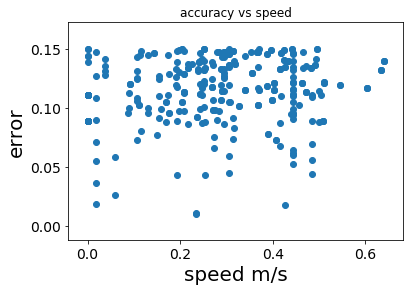

In [20]:
plt.title("accuracy vs speed")
plt.scatter(speeds, errors)
plt.xlabel("speed m/s")
plt.ylabel("error");

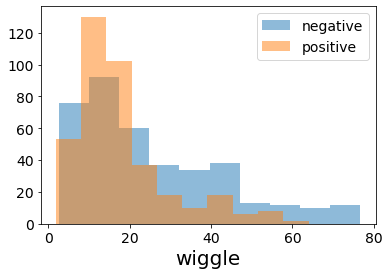

In [21]:
plt.xlabel("wiggle")
plt.hist(negative_wiggle, alpha=0.5, label='negative')
plt.hist(positive_wiggle, alpha=0.5, label='positive')
plt.legend()
plt.show()

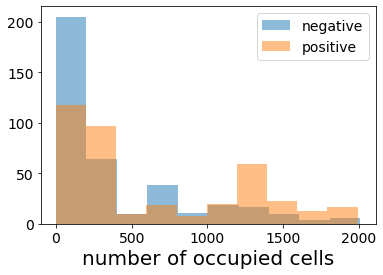

In [22]:
plt.xlabel("number of occupied cells")
plt.hist(negative_occ, alpha=0.5, label='negative')
plt.hist(positive_occ, alpha=0.5, label='positive')
plt.legend()
plt.show()

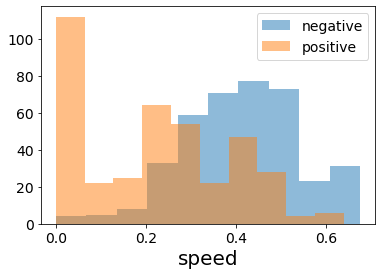

In [23]:
plt.xlabel("speed")
plt.hist(negative_speed, alpha=0.5, label='negative')
plt.hist(positive_speed, alpha=0.5, label='positive')
plt.legend()
plt.show()

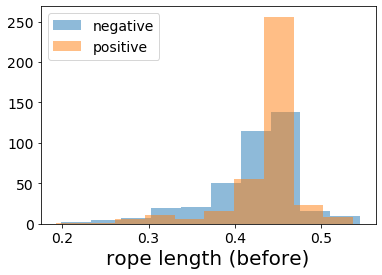

In [24]:
plt.xlabel("rope length (before)")
plt.hist(negative_rope_lengths, alpha=0.5, label='negative')
plt.hist(positive_rope_lengths, alpha=0.5, label='positive')
plt.legend()
plt.show()

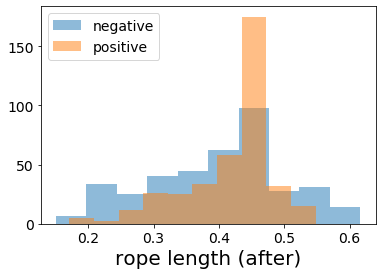

In [25]:
plt.xlabel("rope length (after)")
plt.hist(negative_next_rope_lengths, alpha=0.5, label='negative')
plt.hist(positive_next_rope_lengths, alpha=0.5, label='positive')
plt.legend()
plt.show()

In [26]:
example = next(iter(test_tf_dataset))
state = example['state'].numpy().squeeze()
points = state.reshape(-1, 2)
distances = np.linalg.norm(points[1:] - points[:-1], axis=1)
rope_length = np.sum(distances)
print("actual rope length {:5.3f}".format(rope_length))

actual rope length 0.459
